In [1]:
%load_ext autoreload
import sys
sys.path.append("../../..")

import numpy as np
import pickle
import csv
import config
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

import main as main
from config import load_data
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf
import darkhistory.physics as phys
from darkhistory.physics import ymu_distortion
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectools import rebin_N_arr
from plotting_utils import plot_distortion

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

direc = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'
xnorm = 1 / phys.hbar / 2 / np.pi / 1e9
ynorm = phys.nB * phys.hbar * 2 * np.pi * phys.c * 1e4 * phys.ele / 4 / np.pi

# Compare to distortion from early redshifts

In [2]:
# Load Green's function data from Acharya+Khatri

# First column:  File index
# Second column: redshift
redshifts_1e9 = np.loadtxt(direc+'greens_function/redshift.dat')
redshifts_1e7 = np.loadtxt(direc+'greens_10meve/redshift.dat')

# First column:  Dimensionless frequency x=h\nu/kT_cmb,"nu" is the frequency of the photon
#                Convert to physical frequency via the relation, \nu~56.8*x GHz.
# Second column: Dimensionless intensity (x^3*n), where "n" is the photon occupation number. 
#                The real intensity is given by, I=(2h\nu^3/c^2)*x^3*n, 
#                i.e. multiply by ~2.7*1e-18 W m^-2 Hz^-1 Sr^-1.
greens_fncs = {1e9 : {}, 1e7 : {}}
for index in redshifts_1e9[:,0]:
    greens_fncs[1e9][int(index)] = np.loadtxt(direc+f'greens_function/spectrum_z={index:.0f}.dat')
for index in redshifts_1e7[:,0]:
    greens_fncs[1e7][int(index)] = np.loadtxt(direc+f'greens_10meve/spectrum_z={index:.0f}.dat')

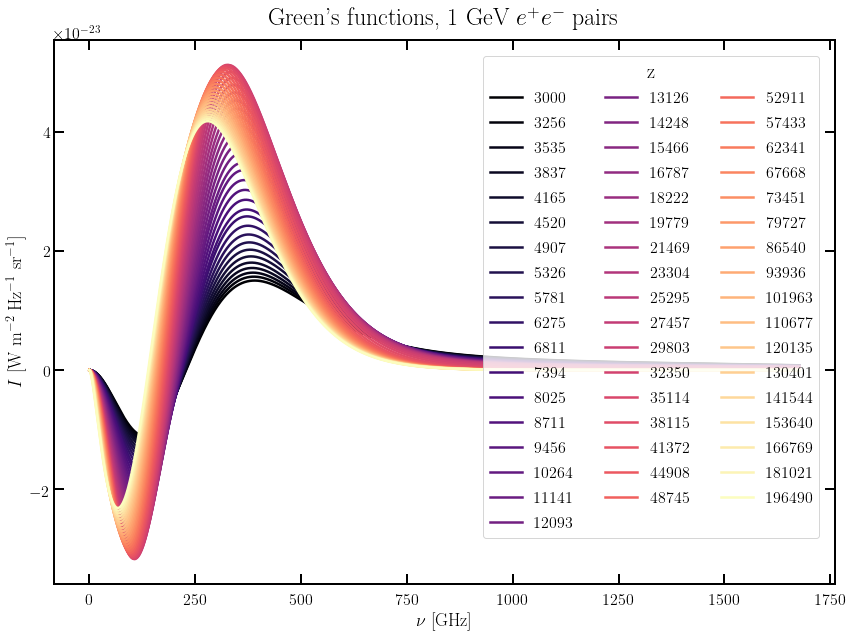

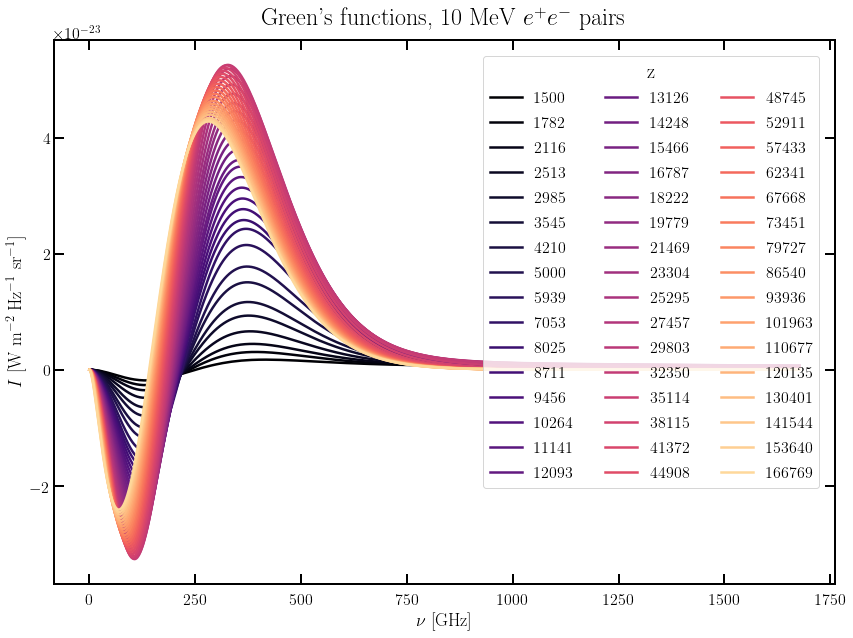

In [3]:
# Pick color scheme
color = cm.magma(np.linspace(0,1,len(redshifts_1e9[:,0])))

# Plot Green's functions for 1GeV e+e- pairs in physical units
plt.figure(figsize=(14,10))

for i, index in enumerate(redshifts_1e9[:,0]):
    plt.plot(56.8 * greens_fncs[1e9][int(index)][:,0], 
             2.7 * 1e-18 * greens_fncs[1e9][int(index)][:,1], 
             label=f'{redshifts_1e9[i,1]:.0f}', color=color[i])

plt.title(r"Green's functions, 1 GeV $e^+ e^-$ pairs")
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$I$ [W m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')
plt.legend(title='z', ncol=3, loc='best')

plt.show()

# Plot Green's functions for 10MeV e+e- pairs in physical units
plt.figure(figsize=(14,10))

for i, index in enumerate(redshifts_1e7[:,0]):
    plt.plot(56.8 * greens_fncs[1e7][int(index)][:,0], 
             2.7 * 1e-18 * greens_fncs[1e7][int(index)][:,1], 
             label=f'{redshifts_1e7[i,1]:.0f}', color=color[i])

plt.title(r"Green's functions, 10 MeV $e^+ e^-$ pairs")
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$I$ [W m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')
plt.legend(title='z', ncol=3, loc='best')

plt.show()

In [4]:
%autoreload

# Injection rate as fnc. of redshift [ev / cm^3 / s]
inj_engs_dec = phys.inj_rate('decay', 1+redshifts_1e9[1:,1], mDM=2e9, lifetime=1e25)
inj_engs_ann = phys.inj_rate('swave', 1+redshifts_1e9[1:,1], mDM=1e9, sigmav=1e-26)

# Multiply by a time step to get energy density [ev/cm^3]
# time step is dt = - dz / (1+z) / H(z), where dz is difference b/w available redshifts
inj_engs_dec *= (redshifts_1e9[1:,1] - redshifts_1e9[:-1,1]) / (1+redshifts_1e9[1:,1]) / phys.hubble(1+redshifts_1e9[1:,1])
inj_engs_ann *= (redshifts_1e9[1:,1] - redshifts_1e9[:-1,1]) / (1+redshifts_1e9[1:,1]) / phys.hubble(1+redshifts_1e9[1:,1])
#inj_engs *= .001 / phys.hubble(test_decay['lowengelec'].rs) #DarkHistory default time step

# Write in units of CMB energy density
inj_engs_dec /= 1e-5 * phys.CMB_eng_density(phys.TCMB(1+redshifts_1e9[1:,1]))
inj_engs_ann /= 1e-5 * phys.CMB_eng_density(phys.TCMB(1+redshifts_1e9[1:,1]))

# Sum Green's fncs over redshifts to get total contribution,[1e9]
# weighted appropriately by injection energy densities
total_distortion_dec = np.zeros_like(greens_fncs[1e9][0])
total_distortion_ann = np.zeros_like(greens_fncs[1e9][0])
total_distortion_dec[:,0] = greens_fncs[1e9][0][:,0]
total_distortion_ann[:,0] = greens_fncs[1e9][0][:,0]

for i, index in enumerate(redshifts_1e9[1:,0]):
    total_distortion_dec[:,1] += inj_engs_dec[i] * greens_fncs[1e9][int(index)][:,1]
    total_distortion_ann[:,1] += inj_engs_ann[i] * greens_fncs[1e9][int(index)][:,1]

In [5]:
%autoreload

# Run DH distortions
mDM = 2e9
tau = 1e25
sigmav=1e-26
species = 'elec'

result_decay = main.evolve(
    DM_process='decay', primary=species+'_delta',
    mDM=mDM, lifetime=tau,
    start_rs = 3000, high_rs=1.555e3, end_rs=4.,
    coarsen_factor=16, rtol=1e-6,
    nmax=10, iterations=2,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    distort=True, fexc_switch=True, reprocess_distortion=True
)
pickle.dump(result_decay, open(direc+'elec_decay_m2e9_full.p','wb'))

result_swave = main.evolve(
    DM_process='swave', primary=species+'_delta',
    mDM=mDM/2, sigmav=sigmav,
    start_rs = 3000, high_rs=1.555e3, end_rs=4.,
    coarsen_factor=16, rtol=1e-6,
    nmax=10, iterations=2,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    distort=True, fexc_switch=True, reprocess_distortion=True
)
pickle.dump(result_swave, open(direc+'elec_swave_m2e9_full.p','wb'))

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


../../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../../../darkhistory/low_energy/atomic.py:412: RuntimeWarning: invalid value encountered in less
  emission_mask[Ennp_mat < 0] *= 0.
../../../darkhistory/low_energy/atomic.py:415: RuntimeWarning: invalid value encountered in greater
  absorption_mask[Ennp_mat > 0] *= 0.
../../../darkhistory/low_energy/atomic.py:418: RuntimeWarning: invalid value encountered in less_equal
  non_pos_mask[(Ennp_mat <= 0) | (np.isnan(Ennp_mat))] = 1.


In [6]:
# Load DH distortions
res_decay = pickle.load(open(direc+'elec_decay_m2e9_full.p','rb'))
result_decay = res_decay[-1]
res_swave = pickle.load(open(direc+'elec_swave_m2e9_full.p','rb'))
result_swave = res_swave[-1]

dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/'
no_DM = pickle.load(open(dir_str+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))

In [7]:
# Interpolate for adding to DH distortion
interp_dec_AK = interp1d(56.8 * total_distortion_dec[:,0], 2.7 * 1e-18 * total_distortion_dec[:,1], bounds_error=False, fill_value=0)
interp_dec_DH = interp1d(result_decay['distortion'].eng * xnorm, result_decay['distortion'].eng * result_decay['distortion'].dNdE * ynorm, bounds_error=False, fill_value=0)

interp_ann_AK = interp1d(56.8 * total_distortion_ann[:,0], 2.7 * 1e-18 * total_distortion_ann[:,1], bounds_error=False, fill_value=0)
interp_ann_DH = interp1d(result_swave['distortion'].eng * xnorm, result_swave['distortion'].eng * result_swave['distortion'].dNdE * ynorm, bounds_error=False, fill_value=0)

interp_SM = interp1d(no_DM['data'][-1]['distortion'].eng * xnorm, no_DM['data'][-1]['distortion'].eng * no_DM['data'][-1]['distortion'].dNdE * ynorm, bounds_error=False, fill_value=0)

def interp_dec_total(eng):
    return interp_dec_AK(eng) + interp_dec_DH(eng)
def interp_ann_total(eng):
    return interp_ann_AK(eng) + interp_ann_DH(eng)

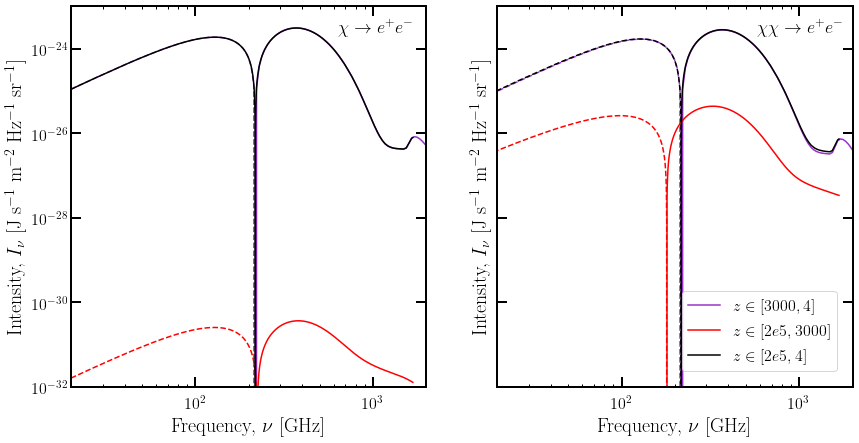

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), sharex=True, sharey=True)

axs[0].loglog()

axs[0].plot(result_decay['distortion'].eng *xnorm, # GHz
         result_decay['distortion'].eng * result_decay['distortion'].dNdE * ynorm - 0*interp_SM(result_decay['distortion'].eng*xnorm),
         label=r'$z \in [3000, 4]$', color='darkorchid', linewidth=1.5) # W Hz^-1 m^-2 sr^{-1}
axs[0].plot(result_decay['distortion'].eng *xnorm, # GHz
         -result_decay['distortion'].eng * result_decay['distortion'].dNdE * ynorm + 0*interp_SM(result_decay['distortion'].eng*xnorm),
         color='darkorchid', linestyle='--', linewidth=1.5) # W Hz^-1 m^-2 sr^{-1}

axs[0].plot(56.8 * total_distortion_dec[:,0], 
         2.7 * 1e-18 * total_distortion_dec[:,1],
         label=r'$z \in [2e5, 3000]$', color='r', linewidth=1.5)
axs[0].plot(56.8 * total_distortion_dec[:,0], 
         - 2.7 * 1e-18 * total_distortion_dec[:,1],
         color='r', linestyle='--', linewidth=1.5)

axs[0].plot(56.8 * total_distortion_dec[:,0], 
         interp_dec_total(56.8 * total_distortion_dec[:,0]),
         label=r'$z \in [2e5, 4]$', color='k', linewidth=1.5)
axs[0].plot(56.8 * total_distortion_dec[:,0], 
         -interp_dec_total(56.8 * total_distortion_dec[:,0]),
         color='k', linewidth=1.5)

axs[0].set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
axs[0].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
axs[0].text(0.75, 0.93, fr"$\chi \rightarrow e^+ e^-$", fontsize=18, transform = axs[0].transAxes)
# axs[0].text(0.61, 0.91, fr"$m_\chi =$ {data[key]['DM_params']['mDM']/1e3:.2f} keV", fontsize=18, transform = ax.transAxes)

axs[1].plot(result_swave['distortion'].eng *xnorm, # GHz
         result_swave['distortion'].eng * result_swave['distortion'].dNdE * ynorm - 0*interp_SM(result_swave['distortion'].eng*xnorm),
         label=r'$z \in [3000, 4]$', color='darkorchid', linewidth=1.5) # W Hz^-1 m^-2 sr^{-1}
axs[1].plot(result_swave['distortion'].eng *xnorm, # GHz
         -result_swave['distortion'].eng * result_swave['distortion'].dNdE * ynorm + 0*interp_SM(result_swave['distortion'].eng*xnorm),
         color='darkorchid', linestyle='--', linewidth=1.5) # W Hz^-1 m^-2 sr^{-1}

axs[1].plot(56.8 * total_distortion_ann[:,0], 
         2.7 * 1e-18 * total_distortion_ann[:,1],
         label=r'$z \in [2e5, 3000]$', color='r', linewidth=1.5)
axs[1].plot(56.8 * total_distortion_ann[:,0], 
         - 2.7 * 1e-18 * total_distortion_ann[:,1],
         color='r', linestyle='--', linewidth=1.5)

axs[1].plot(56.8 * total_distortion_ann[:,0], 
         interp_ann_total(56.8 * total_distortion_ann[:,0]),
         label=r'$z \in [2e5, 4]$', color='k', linewidth=1.5)
axs[1].plot(56.8 * total_distortion_ann[:,0], 
         -interp_ann_total(56.8 * total_distortion_ann[:,0]),
         color='k', linestyle='--', linewidth=1.5)

axs[1].set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
axs[1].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
axs[1].text(0.73, 0.93, fr"$\chi\chi \rightarrow e^+ e^-$", fontsize=18, transform = axs[1].transAxes)
axs[1].legend(loc='lower right')
axs[1].axis([20, 2e3, 1e-32, 1e-23])

plt.savefig(fig_dir+f'high_redshift_distortions.pdf')

# Estimate distortion missing from 1+z < 4

For low masses (e.g. 10 keV), the approximate energy loss rate from Compton scattering should hold. 

Above 10 MeV, photons will tend to lose their energy through kicking ambient electrons up to high energies, and then those electrons ICSing off of the CMB. We can estimate the distortion from high mass dark matter at late times by adding up the spectra of these ICS secondary photons.

In [9]:
### USEFUL FUNCTIONS

# Only have y-distortions at late redshifts, 
# Green's fnc. = Y_SZ/4 at end of page 2 of 1304.6120
def Gy(eng):
    y_spec = ymu_distortion(eng, 1/4, 1, dist_type='y')
    return y_spec.dNdE * phys.nB * eng * (2*np.pi*phys.hbar) * phys.c / 4 / np.pi

# Distortion given by integrating Green's fnc, Eqn 3 of 1304.6120
# In other words, sum Gy from redshifts of interest, weighted by energy in heating
def y_dist_test(eng, res, mDM, z, cf=12):
    weights = (res['f']['low']['heat'] + res['f']['high']['heat']) * phys.inj_rate('decay', res['rs'], mDM=mDM, lifetime=1e25)
    weights /= phys.CMB_eng_density(phys.TCMB(res['rs']))
    return (
        Gy(eng) # Green's function
        * np.sum(weights * .001 * cf / phys.hubble(res['rs'])) # integrate over redshift
        * 1e4 * phys.ele # units of W / m^2 / ster / Hz
    )

# Energy loss (dE / dlnz) due to Compton scattering
#     for a photon of energy E at redshift rs.
def eng_loss_compton(params):
    E, rs = params
    ne = (phys.nH + phys.nHe)*rs**3
    return ne * phys.thomson_xsec * phys.c * E**2 / phys.hubble(rs) / phys.me

def eng_loss_total(E, lnz):
    rs = np.exp(lnz)
    return eng_loss_compton([E, rs]) + E

# Get distortion from old DH results by summing lowengphot
def get_distortion(lowengphots):
    specs_to_sum = deepcopy(lowengphots)
    specs_to_sum.redshift(np.ones_like(specs_to_sum.rs))
    distortion = Spectrum(specs_to_sum[0].eng, 
                            np.zeros_like(specs_to_sum[0].eng), 
                            rs=1, spec_type='N')
    for i, rs in enumerate(specs_to_sum.rs):
        dist_mask = specs_to_sum[i].eng < phys.rydberg / lowengphots[i].rs
        distortion.N[dist_mask] += specs_to_sum[i].N[dist_mask]
    return distortion

In [10]:
# Load DH distortion
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_nmax_200_runs/'
data = {}
data['light'] = pickle.load(open(dir_str+'phot_decay_log10mDM_4.0000_log10param_24.8451_max_CMB_nmax_200_Puchwein_ind_120.p', 'rb'))
data['heavy'] = pickle.load(open(dir_str+'phot_decay_log10mDM_9.3481_log10param_23.9241_max_CMB_nmax_200_Puchwein_ind_143.p', 'rb'))

dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/'
no_DM = pickle.load(open(dir_str+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))

y_comp_late = {}
heating_rate = {}

### 10 keV

In [11]:
# Use Compton energy loss rate for 10 keV model

# Estimate heating from compton scattering 
# by particles injected at late redshifts (1+z < 4)
mDM = data['light']['DM_params']['mDM']
lifetime = data['light']['DM_params']['inj_param']

cf=16
rs_list = np.exp(np.arange(np.log(4), 0, -0.001*cf))
eng_list = data['light']['data'][-1]['distortion'].eng
eng_phot_init = mDM/2

# Number of photons / baryon injected in each redshift step
N_phot = (
    2 # photons per injection event
    * phys.inj_rate('decay', rs_list, mDM=mDM, lifetime=lifetime) / mDM # Number of events per volume per time
    * 0.001*cf / phys.hubble(rs_list) / (phys.nB * rs_list**3) # time per dlnz, volume per baryon
)

heating_rate['light'] = np.zeros_like(rs_list)
# For each injection redshift...
for i, rs in enumerate(rs_list):
    lnzs = np.log(rs_list[i:])
    # Assume spectrum is only two photons injected at mDM/2; cool only by expansion/Compton
    # Get energy of photons at each redshift step
    eng_phot = odeint(eng_loss_total, eng_phot_init, lnzs).flatten() # [eV]
    # Calculate heating rate from Compton
    # Sum over all energies, weighted by N(E)
    heating_rate['light'][i:] += N_phot[i] * eng_loss_compton([eng_phot, np.exp(lnzs)]) # [eV / lnz / baryon]
        
# Normalize to per volume instead of per baryon
heating_rate['light'] *= phys.nB * rs_list**3 # [eV / lnz / cm^3]
heating_rate['light'] /= phys.CMB_eng_density(phys.TCMB(rs_list)) # [1 / lnz]
y_comp_late['light'] = Gy(eng_list) * np.sum(heating_rate['light'] * .001 * cf) * 1e4 * phys.ele # units of W / m^2 / ster / Hz

### 2 GeV

In [14]:
hplanck = phys.hbar * 2 * np.pi

### For heavier DM model, photons will kick up electrons to relativistic energies
### Calculate rate at which electrons are upscattered

mDM = data['heavy']['DM_params']['mDM']
lifetime = data['heavy']['DM_params']['inj_param']

cf = 16
rs_list = np.exp(np.arange(np.log(4), 0, -0.001*cf))
eng_list = data['heavy']['data'][-1]['distortion'].eng
eng_phot_init = mDM/2

heating_rate['heavy'] = np.zeros_like(rs_list)
# y_comp_late['heavy'] = np.zeros_like(eng_list) 

# Number of photons / volume injected in each redshift step
N_phot = (
    2 # photons per injection event
    * phys.inj_rate('decay', rs_list, mDM=mDM, lifetime=lifetime) / mDM # Number of events per volume per time
    * 0.001 * cf / phys.hubble(rs_list) # time per dlnz
)

# Number of scatterings based on Thomson cross section
ne = (phys.nH + 2 * phys.nHe)*rs_list**3
scatter_rate = phys.thomson_xsec * phys.c * N_phot * ne # scatters / cm^3 / s
N_elec = scatter_rate * 0.001 * cf / phys.hubble(rs_list) # upscattered electrons / cm^3 in each redshift step

In [15]:
### Run these through electron cooling module (at 100% ionization) 
### to see how much energy is lost to heating and ICS
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')
ics_tf_data = load_data('ics_tf')
ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

H_states = ['2s', '2p',
            '3s', '3p', '3d',
            '4s', '4p', '4d', '4f',
            '5p', '6p', '7p', '8p', '9p', '10p']
(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

ics_total_spec = np.zeros_like(eng_list) 

for ii, rs in enumerate(tqdm(rs_list)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII=1, xHeII=phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            simple_ICS=False,
            check_conservation_eng=False,
            H_states=H_states
    )

    # Make rate of scattered electrons into a spectrum
    elec_spec = rebin_N_arr(np.array([scatter_rate[ii]]), np.array([eng_phot_init - phys.me]), eleceng, spec_type='N') # [electrons / cm^3 / s]

    ### Sum up secondary ICS photons. Make sure to normalize to per baryon.
    ics_phot_spec = ics_sec_phot_tf.sum_specs(elec_spec * 0.001*cf / phys.hubble(rs) / (phys.nB * rs**3))
    ics_phot_spec.redshift(1)
    ics_interp = interp1d(
        ics_phot_spec.eng, 
        ics_phot_spec.dNdE * (phys.nB * ics_phot_spec.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4), 
        bounds_error=False, fill_value=0
    )
    # ics_phot_spec.rebin(eng_list)
    # y_comp_late['heavy'] += ics_phot_spec.dNdE * convert
    ics_total_spec += ics_interp(eng_list)
    
    # Calculate additional contribution from heating.
    heating_rate['heavy'][ii] = np.dot(
        deposited_heat_arr, elec_spec.N # [eV / cm^3 / s]
    )

In [16]:
# Photons lose all energy to heat
heating_rate['heavy'] /= phys.hubble(rs_list) # [eV / cm^3 / lnz]
heating_rate['heavy'] /= phys.CMB_eng_density(phys.TCMB(rs_list)) # [1 / lnz]

# Convert heating rate to y-type distortion
heating_spec = Gy(eng_list) * np.sum(heating_rate['heavy'] * .001 * cf) * 1e4 * phys.ele # units of W / m^2 / ster / Hz
y_comp_late['heavy'] = ics_total_spec + heating_spec # units of W / m^2 / ster / Hz

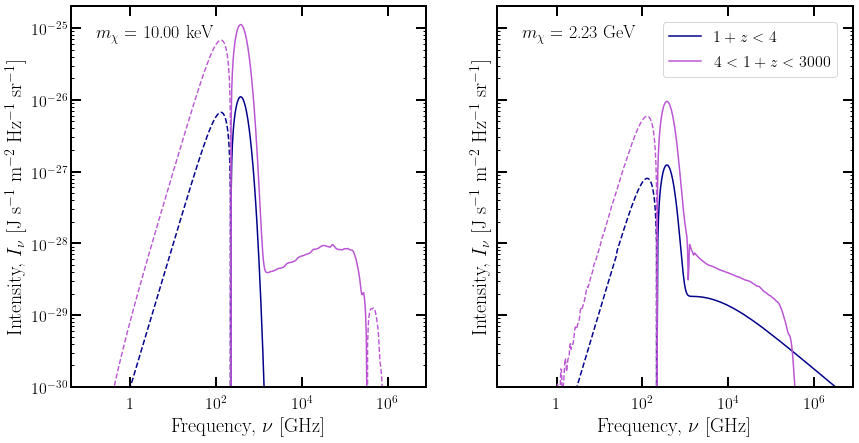

In [17]:
convert = phys.nB * data['light']['data'][-1]['distortion'].eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
cs = ['mediumorchid', 'darkblue']

fig, axs = plt.subplots(1, 2, figsize=(14,7), sharex=True, sharey=True)

for ii, ax in enumerate(axs):
    if ii == 0:
        key = 'light'
    else:
        key = 'heavy'

    ax.loglog()
    ax.plot(eng_list * xnorm, # GHz
            y_comp_late[key], # W Hz^-1 m^-2 sr^{-1}, 
            color=cs[1], linewidth=1.5, label='$1+z < 4$')
    ax.plot(eng_list * xnorm, # GHz
            -y_comp_late[key], # W Hz^-1 m^-2 sr^{-1}, 
            color=cs[1], linewidth=1.5, linestyle='--')

    # if ii==1:
    #     ax.plot(eng_list * xnorm, # GHz
    #             heating_spec, # W Hz^-1 m^-2 sr^{-1}, 
    #             color='pink', linewidth=1.5, label='heat')
    #     ax.plot(eng_list * xnorm, # GHz
    #             -heating_spec, # W Hz^-1 m^-2 sr^{-1}, 
    #             color='pink', linewidth=1.5, linestyle='--')
    #     ax.plot(eng_list * xnorm, # GHz
    #             ics_total_spec, # W Hz^-1 m^-2 sr^{-1}, 
    #             color='green', linewidth=1.5, label='ICS')
    #     ax.plot(eng_list * xnorm, # GHz
    #             -ics_total_spec, # W Hz^-1 m^-2 sr^{-1}, 
    #             color='green', linewidth=1.5, linestyle='--')

    ax.plot(
        data[key]['data'][-1]['distortion'].eng*xnorm, 
        convert * (data[key]['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
        color=cs[0], linestyle='solid', linewidth=1.5, 
        label=r'$4 < 1+z < 3000$'
    )
    ax.plot(
        data[key]['data'][-1]['distortion'].eng*xnorm, 
        -convert * (data[key]['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
        color=cs[0], linestyle='--', linewidth=1.4,
    )

    ax.set_ylim(1e-30, 2e-25)
    ax.set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    ax.set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
    if ii==0:
        ax.text(0.07, 0.91, fr"$m_\chi =$ {data[key]['DM_params']['mDM']/1e3:.2f} keV", fontsize=18, transform = ax.transAxes)
    else:
        ax.text(0.07, 0.91, fr"$m_\chi =$ {data[key]['DM_params']['mDM']/1e9:.2f} GeV", fontsize=18, transform = ax.transAxes)
        ax.legend(loc='upper right')

plt.savefig(fig_dir+f'low_redshift_distortions.pdf')

## Alternative: estimate distortion missing from 1+z < 4 assume photon's energy all goes to heating

In [ ]:
y_comp_late = {}
heating_rate_dict = {}
for key in ['light', 'heavy']:
    mDM = data[key]['DM_params']['mDM']
    lifetime = data[key]['DM_params']['inj_param']
    print(key, lifetime)

    rs_list = np.exp(np.arange(np.log(4), 0, -0.001*16))
    eng_list = data[key]['data'][-1]['distortion'].eng
    eng_phot_init = mDM/2

    # Number of photons / baryon injected in each redshift step
    N_phot = (
        2 # photons per injection event
        * phys.inj_rate('decay', rs_list, mDM=mDM, lifetime=lifetime) / mDM # Number of events per volume per time
        * 0.001 / phys.hubble(rs_list) / (phys.nB * rs_list**3) # time per dlnz, volume per baryon
    )
    # Scattering much slower than Hubble, so number of photons accumulates with each redshift
    # Normalize to per volume
    N_phot_cum = np.cumsum(N_phot) * (phys.nB * rs_list**3)

    # Number of scatterings based on Thomson cross section
    ne = (phys.nH + phys.nHe)*rs_list**3
    scatter_rate = phys.thomson_xsec * phys.c * N_phot_cum * ne # scatters / cm^3 / s

    # Photons lose all energy to heat
    heating_rate_test = eng_phot_init * scatter_rate # [eV / cm^3 / s]
    heating_rate_test /= phys.hubble(rs_list) # [eV / cm^3 / lnz]
    heating_rate_test /= phys.CMB_eng_density(phys.TCMB(rs_list)) # [1 / lnz]
    heating_rate_dict[key] = heating_rate_test

    # Convert heating rate to y-type distortion
    y_comp_late[key] = Gy(eng_list) * np.sum(heating_rate_test * .001) * 1e4 * phys.ele # units of W / m^2 / ster / Hz

In [ ]:
# Compare energy loss rate to Hubble loss rate

lnzs = np.log(rs_list)
# Assume spectrum is only two photons injected at mDM/2; cool only by expansion/Compton
# Get energy of photons at each redshift step
eng_phot = odeint(eng_loss_total, eng_phot_init, lnzs).flatten() # [eV]
# Calculate heating rate from Compton
# Sum over all energies, weighted by N(E)
compton_loss_test = eng_loss_compton([eng_phot, np.exp(lnzs)]) # [eV / lnz / baryon]

plt.figure()
plt.loglog()
plt.plot(rs_list, compton_loss_test, label='compton')
plt.plot(rs_list, eng_phot, label='Hubble')
plt.ylabel('dE/dlnz')
plt.xlabel('1+z')
plt.legend(loc='best')
plt.show()